In [1]:
# Monter Google Drive (demande l'autorisation une fois par notebook)
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
# Installer les dépendances (à adapter selon ton requirements)
!pip install -r /content/drive/MyDrive/pcp/requirements.txt
# Ajouter le dossier pcp dans sys.path pour importer tes modules locaux
import sys
repo_path = '/content/drive/MyDrive/pcp'
if repo_path not in sys.path:
    sys.path.append(repo_path)

In [54]:

import utils_contrib
import importlib
importlib.reload(utils_contrib)


<module 'utils_contrib' from '/content/drive/MyDrive/pcp/utils_contrib.py'>

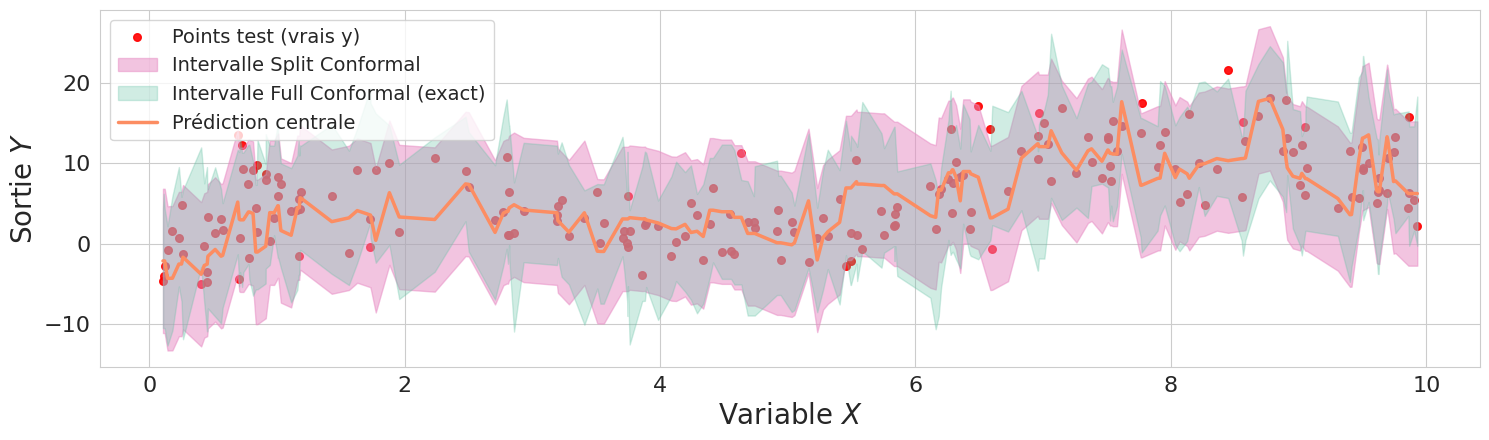

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from tqdm import tqdm  # facultatif: barre de progression si installé

sns.set_style("whitegrid")
set2_colors = sns.color_palette("Set2")
np.random.seed(42)

# --- 1. Données synthétiques ---
n_total = 500
X = np.random.uniform(0, 10, size=(n_total, 1))
y = X.ravel() + 3.5 * np.sin(X).ravel() + 4 * np.random.randn(n_total)

n_train = 150
n_calib = 150
X_train, y_train = X[:n_train], y[:n_train]
X_calib, y_calib = X[n_train:n_train+n_calib], y[n_train:n_train+n_calib]
X_test, y_test = X[n_train+n_calib:], y[n_train+n_calib:]   # ATTENTION : on récupère aussi y_test ici

# --- 2. Split Conformal ---
model_split = RandomForestRegressor()
model_split.fit(X_train, y_train)

y_calib_pred = model_split.predict(X_calib)
residuals_split = np.abs(y_calib - y_calib_pred)
alpha = 0.1
q_split = np.quantile(residuals_split, 1 - alpha)
y_test_pred = model_split.predict(X_test)
intervals_split = np.full_like(y_test_pred, q_split)

# --- 3. Full Conformal exact (méthode correcte et robuste) ---
X_train_calib = np.vstack([X_train, X_calib])
y_train_calib = np.concatenate([y_train, y_calib])

# largeur de grid recommandée : basé sur q_split (plus robuste que sigma brut)
grid_half_range_base = max(3 * q_split, np.std(y_calib - y_calib_pred) * 2)
y_grid_res = 30  # résolution (+ élevé = plus précis, + lent)

intervals_full_lower = np.empty(len(X_test))
intervals_full_upper = np.empty(len(X_test))

# Boucle sur chaque point test (coûteux) — on peut afficher une progression si tqdm installé
iterator = enumerate(X_test)
# iterator = tqdm(enumerate(X_test), total=len(X_test))  # décommentez si tqdm est installé

for i, x_new in iterator:
    y_pred = y_test_pred[i]
    # on commence par un grid centré et raisonnable
    half_range = grid_half_range_base
    included = []

    # on fera jusqu'à 3 tentatives en élargissant progressivement le grid si aucun y_cand accepté
    for attempt in range(3):
        y_grid = np.linspace(y_pred - half_range, y_pred + half_range, y_grid_res)
        included = []
        for y_cand in y_grid:
            # ajouter le point candidat (x_new, y_cand)
            X_aug = np.vstack([X_train_calib, x_new.reshape(1, -1)])
            y_aug = np.append(y_train_calib, y_cand)
            model_fc = RandomForestRegressor().fit(X_aug, y_aug)
            scores = np.abs(y_aug - model_fc.predict(X_aug))
            # critère de Full Conformal exact
            if scores[-1] <= np.quantile(scores, 1 - alpha):
                included.append(y_cand)
        if len(included) > 0:
            break
        # sinon on élargit le grid (doublage) et on réessaie
        half_range *= 2

    # si toujours rien (extrêmement rare), on tombe sur la solution Split (sécurité)
    if len(included) == 0:
        intervals_full_lower[i] = y_pred - q_split
        intervals_full_upper[i] = y_pred + q_split
    else:
        intervals_full_lower[i] = np.min(included)
        intervals_full_upper[i] = np.max(included)



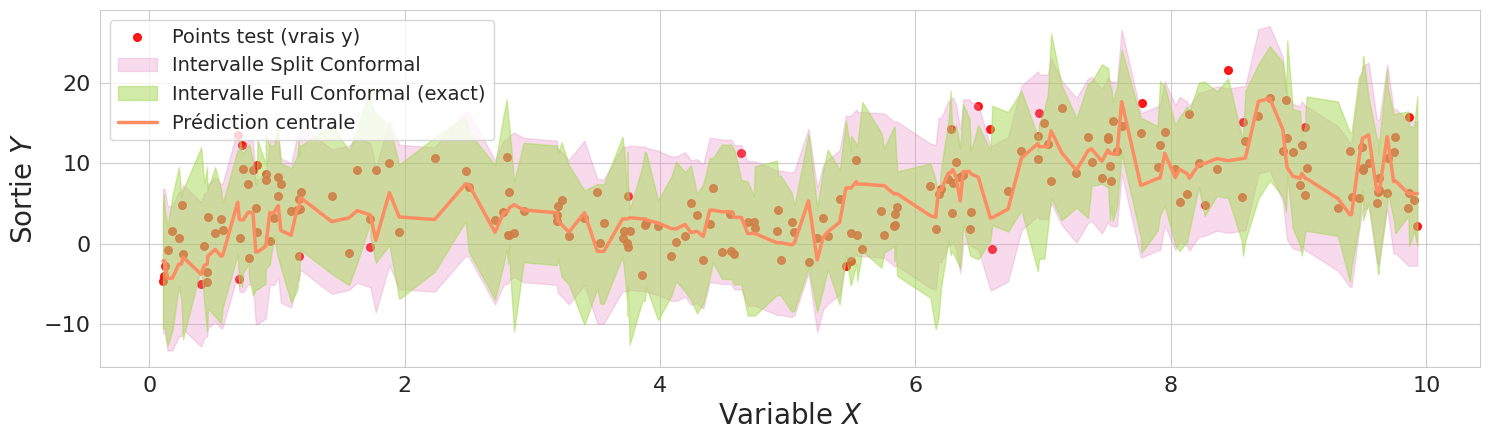

In [11]:
# --- 4. Tri pour le graphique ---
indices = np.argsort(X_test[:, 0])
predictions = y_test_pred

# --- 5. Figure (style conservé) ---
fig, ax = plt.subplots(figsize=(15, 4.5))
fig.subplots_adjust(left=0.09, right=0.975, top=0.95, bottom=0.2)

# Points test réels (en rouge pour bien voir couverture)
ax.scatter(X_test[indices, 0], y_test[indices], alpha=0.9, color="red", s=30, label="Points test (vrais y)")

# Intervalle Split Conformal
ax.fill_between(X_test[indices, 0],
                predictions[indices] - intervals_split[indices],
                predictions[indices] + intervals_split[indices],
                alpha=0.3, color=set2_colors[3], label="Intervalle Split Conformal")

# Intervalle Full Conformal exact
ax.fill_between(X_test[indices, 0],
                intervals_full_lower[indices],
                intervals_full_upper[indices],
                alpha=0.5, color=set2_colors[4], label="Intervalle Full Conformal (exact)")

# Prédiction centrale (ligne)
ax.plot(X_test[indices, 0], predictions[indices], color=set2_colors[1], lw=2.5, label="Prédiction centrale")

# Axes et légende
ax.set_xlabel("Variable $X$", fontsize=20)
ax.set_ylabel("Sortie $Y$", fontsize=20)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.legend(fontsize=14)

plt.tight_layout()
fig.savefig("split_vs_full_conformal_exact_fixed.pdf", bbox_inches='tight', dpi=300)
plt.show()


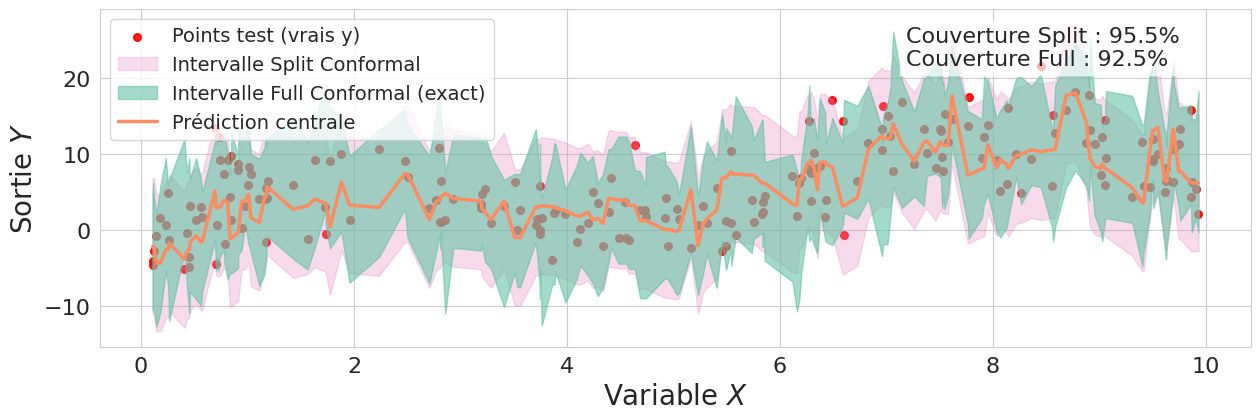

In [19]:
# --- Calcul de la couverture empirique ---
coverage_split = np.mean(
    (y_test >= predictions - intervals_split) & (y_test <= predictions + intervals_split)
)
coverage_full = np.mean(
    (y_test >= intervals_full_lower) & (y_test <= intervals_full_upper)
)

# --- Ajouter annotation sur la figure ---
fig, ax = plt.subplots(figsize=(13, 4.5))
fig.subplots_adjust(left=0.09, right=0.975, top=0.95, bottom=0.2)

ax.scatter(X_test[indices, 0], y_test[indices], alpha=0.9, color="red", s=30, label="Points test (vrais y)")

ax.fill_between(X_test[indices, 0],
                predictions[indices] - intervals_split[indices],
                predictions[indices] + intervals_split[indices],
                alpha=0.3, color=set2_colors[3], label="Intervalle Split Conformal")

ax.fill_between(X_test[indices, 0],
                intervals_full_lower[indices],
                intervals_full_upper[indices],
                alpha=0.6, color=set2_colors[0], label="Intervalle Full Conformal (exact)")

ax.plot(X_test[indices, 0], predictions[indices], color=set2_colors[1], lw=2.5, label="Prédiction centrale")

# Axes et légende
ax.set_xlabel("Variable $X$", fontsize=20)
ax.set_ylabel("Sortie $Y$", fontsize=20)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.legend(fontsize=14)

# Annotation couverture
ax.text(0.70, 0.95,
        f"Couverture Split : {coverage_split*100:.1f}%\nCouverture Full : {coverage_full*100:.1f}%",
        transform=ax.transAxes, fontsize=16, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# plt.tight_layout()
fig.savefig("split_vs_full_conformal_coverage.pdf", bbox_inches='tight', dpi=300)
plt.show()


In [50]:
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from utils import PCP, RLCP, CC, SCP, train_val_test_split, simulate_data
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

seed = 123456
np.random.seed(seed)

alpha = 0.1
num_samples = 1500
setting = 1

X, Y = simulate_data(num_samples,setting)
X_train, X_val, X_test, Y_train, Y_val, Y_test, X_test_0 = train_val_test_split(X,Y,1/3)

In [44]:
RF = RandomForestRegressor(random_state=123456).fit(X_train, Y_train)

predictions_val = RF.predict(X_val)
R_val = abs(Y_val - predictions_val)
predictions = RF.predict(X_test)
R_test = abs(Y_test - predictions)

kf = KFold(n_splits=5, random_state=123456, shuffle=True)
R_train = []
X_train_ = []

for train_index, val_index in kf.split(X_train):
    RF_k = RandomForestRegressor()
    RF_k.fit(X_train[train_index], Y_train[train_index])
    Y_val_pred = RF_k.predict(X_train[val_index])
    X_train_.append(X_train[val_index])
    R_train.append(abs(Y_train[val_index] - Y_val_pred))

R_train = np.concatenate(R_train)
X_train = np.concatenate(X_train_)

In [45]:
PCP_model = PCP()
PCP_model.train(X_train,R_train, info = True)
q_pcp, coverage_pcp, pi_list = PCP_model.calibrate(X_val, R_val,X_test, R_test, alpha,return_pi= True)

r_square: 0.9744166656700445
number of components: 5
sample size m: 12


500it [01:20,  6.20it/s]
500it [00:35, 14.17it/s]


In [78]:
from utils_contrib import *

import matplotlib.pyplot as plt
import numpy as np

K =4     # nombre de clusters
m = 12      # nombre d'échantillons pour random.choices
pi_opt, mu, F, _ = algo_sousgradient_projete_residus(R_val, X_val,K=K,lambda_pen=1e-2)

print(pi_opt[:5])
pi_test = approx_pi_test(pi_opt, X_val, X_test)
print("Probabilités π pour le test :\n", pi_test[:5])


[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]
Probabilités π pour le test :
 [[9.20491719e-01 7.77414023e-02 9.74349437e-04 7.92529670e-04]
 [9.50213089e-01 4.83063257e-02 7.88262030e-04 6.92322749e-04]
 [9.72230936e-01 2.77690640e-02 0.00000000e+00 0.00000000e+00]
 [8.70261595e-01 1.27429003e-01 1.40369691e-03 9.05704614e-04]
 [9.17069417e-01 8.04135067e-02 1.50196012e-03 1.01511598e-03]]


In [112]:
n_cluster=5
q_pcp_split,pi=calibrate_pcp_split(X_val,R_val,X_test,R_test,
                                   n_cluster,m,alpha,
                                   return_pi=True,max_iter=20,
                                   lambda_pen=0.001)

In [111]:
print(q_pcp_split[:5])
print(pi[:5])

[         inf 175.96885484          inf          inf          inf]
[[0.         0.01132847 0.32955718 0.32955718 0.32955718]
 [0.05480151 0.0663674  0.31934169 0.28295759 0.27653182]
 [0.05297606 0.00885919 0.31905819 0.30955329 0.30955329]
 [0.019033   0.03011926 0.3317383  0.3106058  0.30850365]
 [0.05039819 0.02646461 0.33369477 0.29746769 0.29197475]]


(-190.0, 190.0)

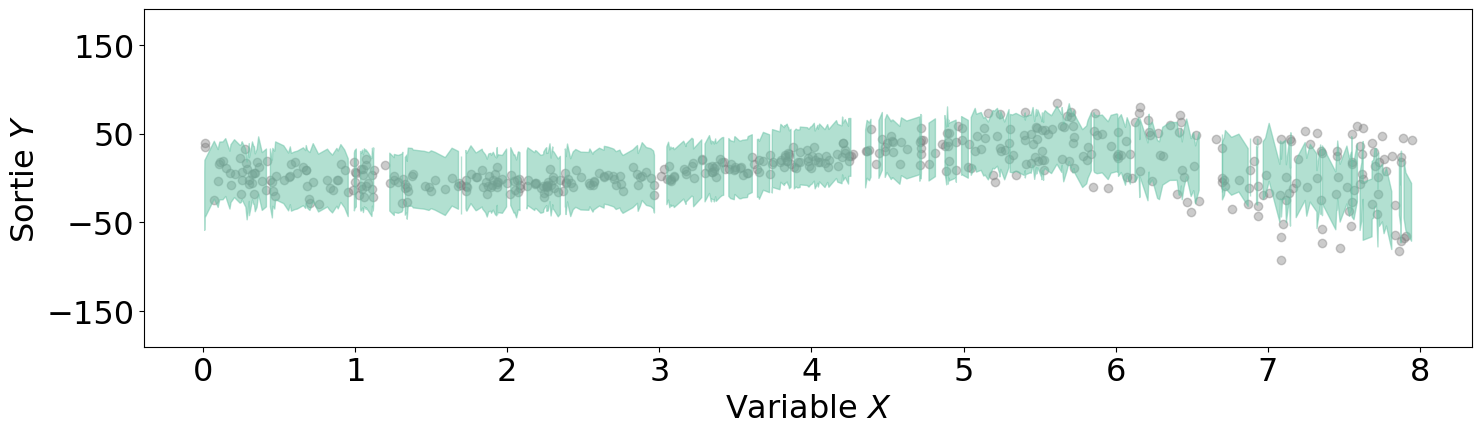

In [145]:
feature = 0
indices = np.argsort(X_test_0[:,feature])
set2_colors = sns.color_palette("Set2")

fig, ax = plt.subplots(figsize=(15,4.5))
fig.subplots_adjust(left=0.09,right=0.975,top=0.95,bottom=0.2,wspace=0.25, hspace=0.25)

ax.scatter(X_test_0[indices,feature], Y_test[indices], alpha=0.4,color = "tab:grey")
ax.fill_between(X_test_0[indices,feature], predictions[indices] -np.array(q_pcp_split)[indices], predictions[indices]+np.array(q_pcp_split)[indices], alpha=0.5,color= set2_colors[0])
ax.set_xlabel("Variable $X$", fontsize=23)
ax.set_ylabel("Sortie $Y$",fontsize=23)
ax.tick_params(axis='x', labelsize=23)
ax.tick_params(axis='y', labelsize=23)
ax.set_yticks(np.arange(-150, 151, step=100))
ax.set_ylim(-190,190)


In [121]:
from utils_contrib import pcp_full_prediction_intervals
sigma = np.std(Y_train, ddof=1)
factor = 2
n_grid = 10

grids_per_test = [np.linspace(mu - factor*sigma, mu + factor*sigma, n_grid) for mu in predictions]

print("Centre (mu_new[0]):", predictions[0])
print("Extrait de la grille:", grids_per_test[0])
all_Ry_test = []

for j, x_test in enumerate(X_test):
    Ry_matrix = np.abs(predictions[j] - grids_per_test[j])
    all_Ry_test.append(Ry_matrix)

print("Nb points test:", len(all_Ry_test))
print("Shape R^y pour le premier test:", np.array(all_Ry_test).shape)  # (200, n_train)


Centre (mu_new[0]): 0.3853728079109797
Extrait de la grille: [-56.18842692 -43.61647142 -31.04451593 -18.47256043  -5.90060494
   6.67135056  19.24330605  31.81526154  44.38721704  56.95917253]
Nb points test: 500
Shape R^y pour le premier test: (500, 10)


In [139]:
interval=pcp_full_prediction_intervals(X_test, predictions,
                                       X_val, R_val,R_test,
                                       grids_per_test,m,n_cluster,
                                       alpha=0.1,max_iter=10,
                                       tol=1e-3,lambda_pen=0.1)

KeyboardInterrupt: 

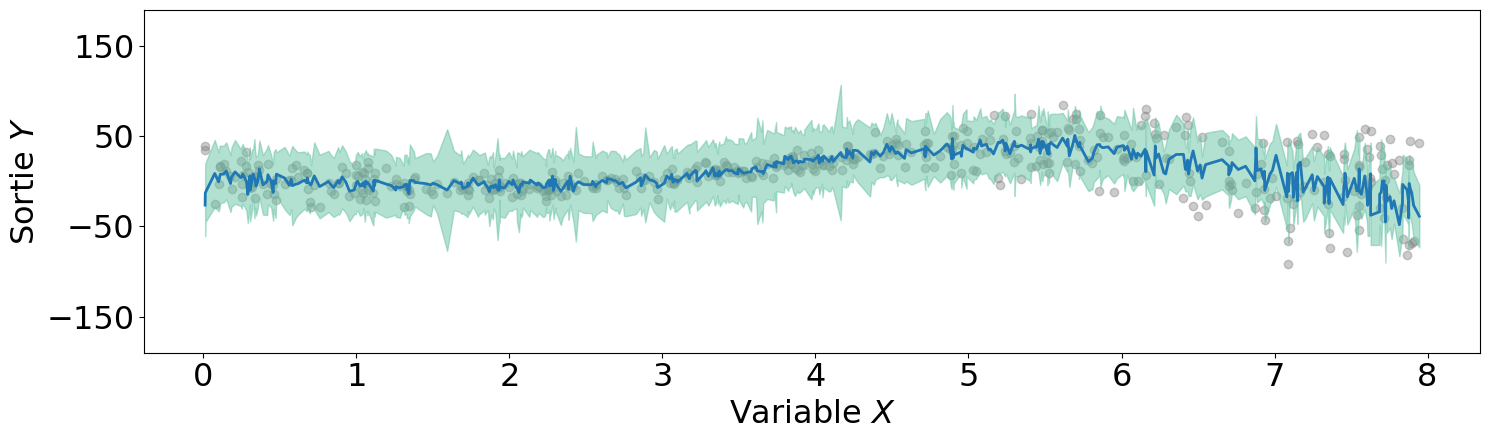

In [138]:
intervals = np.array(interval[0], dtype=float)  # prend seulement la liste de floats

feature = 0
indices = np.argsort(X_test_0[:,feature])
set2_colors = sns.color_palette("Set2")

fig, ax = plt.subplots(figsize=(15,4.5))
fig.subplots_adjust(left=0.09,right=0.975,top=0.95,bottom=0.2)

# scatter des points
ax.scatter(X_test_0[indices,feature], Y_test[indices], alpha=0.4, color="tab:grey")

# intervalle PCP
ax.fill_between(X_test_0[indices,feature],
                predictions[indices]-intervals[indices],
                predictions[indices]+intervals[indices],
                alpha=0.5, color=set2_colors[0])

# prédiction centrale (optionnel)
ax.plot(X_test_0[indices,feature], predictions[indices], color="tab:blue", lw=2)

# axes
ax.set_xlabel("Variable $X$", fontsize=23)
ax.set_ylabel("Sortie $Y$", fontsize=23)
ax.tick_params(axis='x', labelsize=23)
ax.tick_params(axis='y', labelsize=23)
ax.set_yticks(np.arange(-150, 151, step=100))
ax.set_ylim(-190,190)

plt.tight_layout()
fig.savefig("full_pcplambda1.pdf", bbox_inches='tight')  # sauvegarde correcte
plt.show()

In [95]:
q_pcp_split[:5],pi[:1]

(array([97.90123934, 97.90123934, 97.90123934, 97.90123934, 97.90123934]),
 array([[0.        , 0.        , 0.07017171, 0.92982829]]))

# code perso

100%|██████████| 2000/2000 [00:00<00:00, 10996.54it/s]


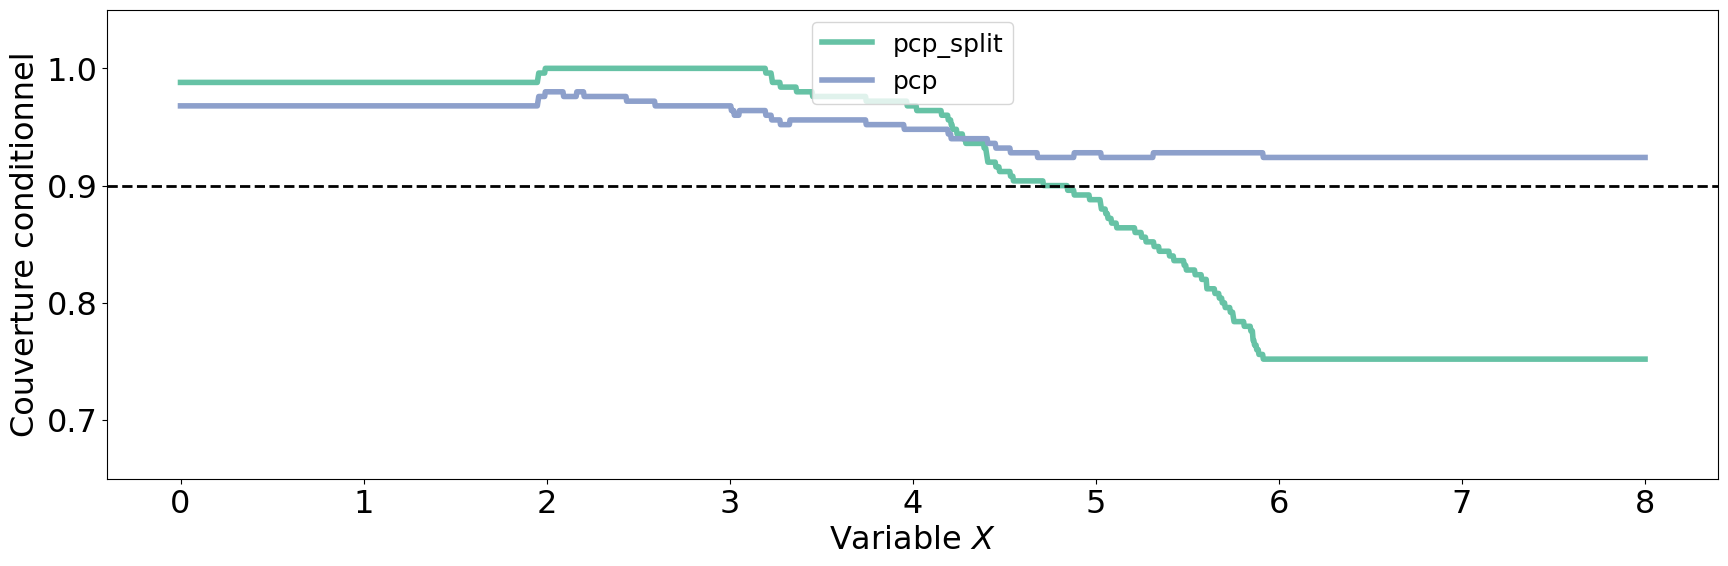

In [144]:



feature = 0

x_grid = np.linspace(0, 8, 2000)
indices = np.argsort(X_test[:,feature])
coverage_pcp_1=[]
coverage_pcp_split_1 = []


for x in tqdm(x_grid):
    idx = np.array(abs(x - X_test_0[:,feature])).argsort()[:250]
    coverage_pcp_split_1.append(np.mean(np.array(q_pcp_split)[idx]>=R_test[idx]))
    coverage_pcp_1.append(np.mean(np.array(q_pcp)[idx]>=R_test[idx]))

set2_colors = sns.color_palette("Set2")
# Création de la figure
fig, ax = plt.subplots(figsize=(18,7))
fig.subplots_adjust(left=0.08, right=0.975, top=0.82, bottom=0.15)

# Trace des courbes
ax.plot(x_grid, coverage_pcp_split_1, color=set2_colors[0], linewidth=4, label="pcp_split")
ax.plot(x_grid, coverage_pcp_1, color=set2_colors[2], linewidth=4, label="pcp")
# Ligne de référence
ax.axhline(y=0.9, color='black', linestyle='--', linewidth=2)
ax.tick_params(axis='x', labelsize=23)
ax.tick_params(axis='y', labelsize=23)
ax.legend(fontsize=18, loc='upper center')

ax.set_xlabel("Variable $X$", fontsize=23)
ax.set_ylabel("Couverture conditionnel", fontsize=23)
ax.set_ylim((0.65,1.05))
ax.set_yticks(np.arange(0.7, 1.01, step=0.1))

fig.savefig("coverage_plot.pdf", bbox_inches='tight')
plt.show()
plt.close(fig)

In [65]:
q_scp, coverage_scp = SCP(R_val, R_test, alpha)
q_rlcp, coverage_rlcp = RLCP(X_train, X_val, R_val, X_test, R_test, alpha)

In [66]:
lbs, ubs, length_cc, coverage_cc = CC(RF, X_val, Y_val,  X_test, Y_test, alpha)

/usr/local/lib/python3.12/dist-packages/cvxpy/atoms/affine/vec.py:40: FutureWarning: 
    You didn't specify the order of the vec expression. The default order
    used in CVXPY is Fortran ('F') order. This default will change to match NumPy's
    default order ('C') in a future version of CVXPY.
    To suppress this warning, please specify the order explicitly.
    
  warnings.warn(vec_order_warning, FutureWarning)
100%|██████████| 500/500 [00:12<00:00, 40.02it/s]


(-190.0, 190.0)

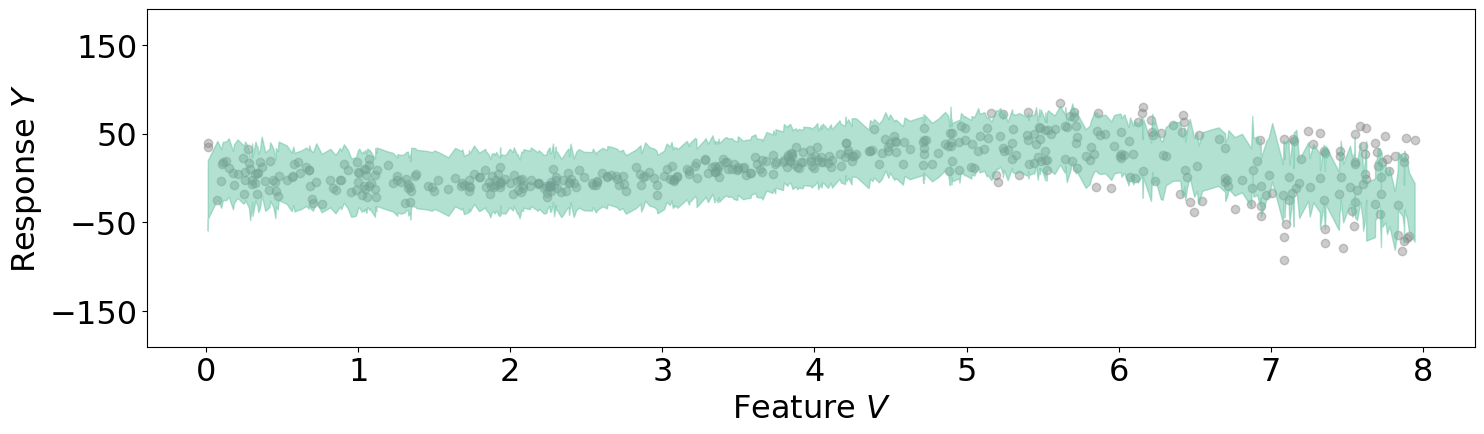

In [127]:
feature = 0
indices = np.argsort(X_test_0[:,feature])
set2_colors = sns.color_palette("Set2")

fig, ax = plt.subplots(figsize=(15,4.5))
fig.subplots_adjust(left=0.09,right=0.975,top=0.95,bottom=0.2,wspace=0.25, hspace=0.25)

ax.scatter(X_test_0[indices,feature], Y_test[indices], alpha=0.4,color = "tab:grey")
ax.fill_between(X_test_0[indices,feature], predictions[indices] -np.array(q_scp)[indices], predictions[indices]+np.array(q_scp)[indices], alpha=0.5,color= set2_colors[0])
ax.set_xlabel("Feature $V$", fontsize=23)
ax.set_ylabel("Response $Y$",fontsize=23)
ax.tick_params(axis='x', labelsize=23)
ax.tick_params(axis='y', labelsize=23)
ax.set_yticks(np.arange(-150, 151, step=100))
ax.set_ylim(-190,190)

(-190.0, 190.0)

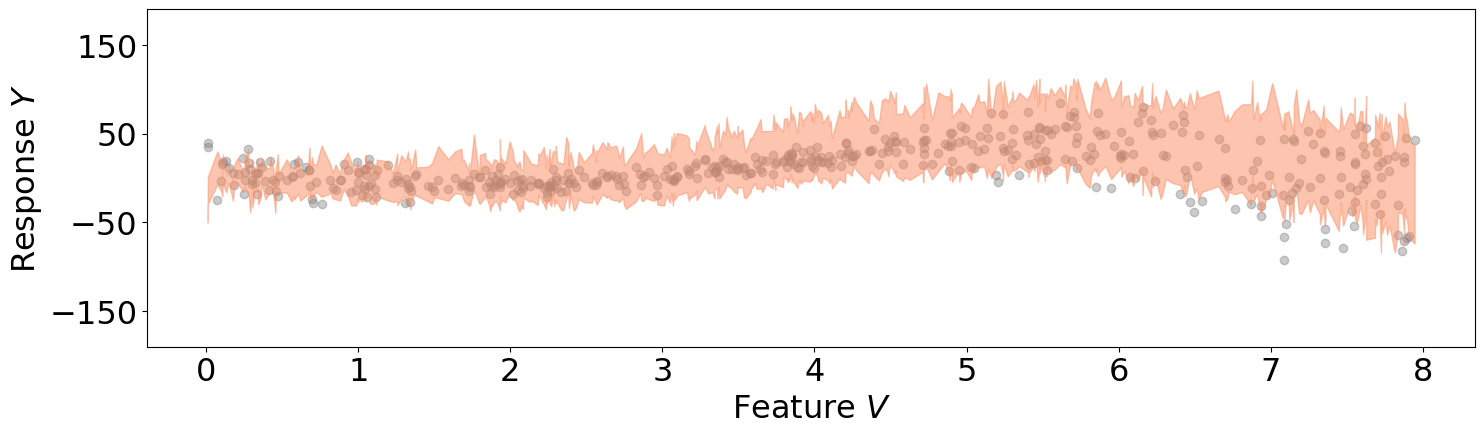

In [128]:
feature = 0
indices = np.argsort(X_test_0[:,feature])
set2_colors = sns.color_palette("Set2")

fig, ax = plt.subplots(figsize=(15,4.5))
fig.subplots_adjust(left=0.09,right=0.975,top=0.95,bottom=0.2,wspace=0.25, hspace=0.25)

ax.scatter(X_test_0[indices,feature], Y_test[indices], alpha=0.4,color = "tab:grey")
ax.fill_between(X_test_0[indices,feature], np.array(lbs)[indices], np.array(ubs)[indices], alpha=0.5,color= set2_colors[1])
ax.set_xlabel("Feature $V$", fontsize=23)
ax.set_ylabel("Response $Y$",fontsize=23)
ax.tick_params(axis='x', labelsize=23)
ax.tick_params(axis='y', labelsize=23)
ax.set_yticks(np.arange(-150, 151, step=100))
ax.set_ylim(-190,190)

(-190.0, 190.0)

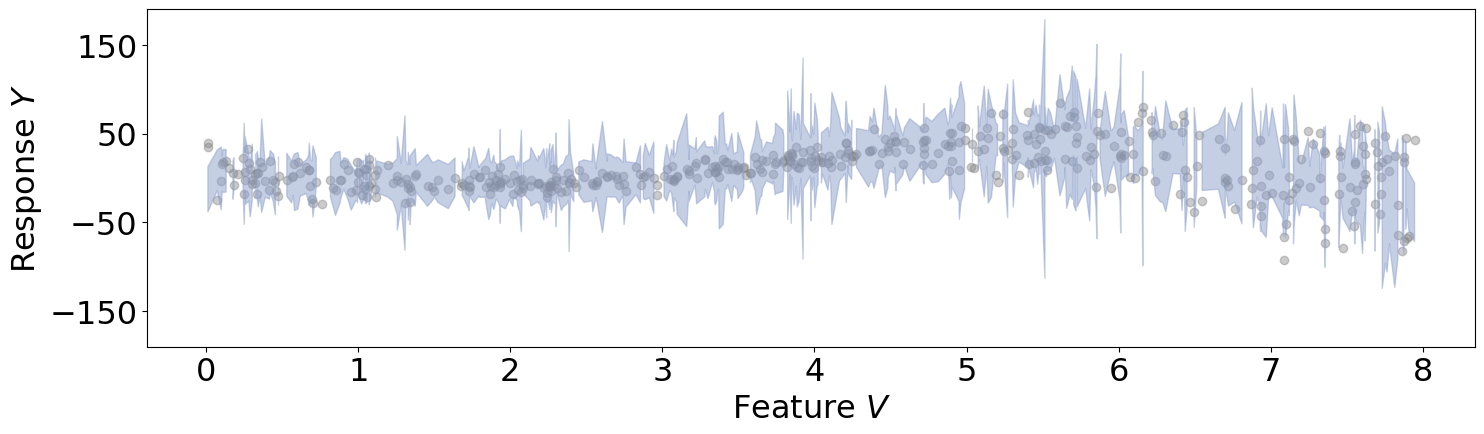

In [129]:
feature = 0
indices = np.argsort(X_test_0[:,feature])
set2_colors = sns.color_palette("Set2")

fig, ax = plt.subplots(figsize=(15,4.5))
fig.subplots_adjust(left=0.09,right=0.975,top=0.95,bottom=0.2,wspace=0.25, hspace=0.25)

ax.scatter(X_test_0[indices,feature], Y_test[indices], alpha=0.4,color = "tab:grey")
ax.fill_between(X_test_0[indices,feature], predictions[indices]
                 -np.array(q_rlcp)[indices], predictions[indices]
                 +np.array(q_rlcp)[indices], alpha=0.5,color= set2_colors[2])
ax.set_xlabel("Feature $V$", fontsize=23)
ax.set_ylabel("Response $Y$",fontsize=23)
ax.tick_params(axis='x', labelsize=23)
ax.tick_params(axis='y', labelsize=23)
ax.set_yticks(np.arange(-150, 151, step=100))
ax.set_ylim(-190,190)

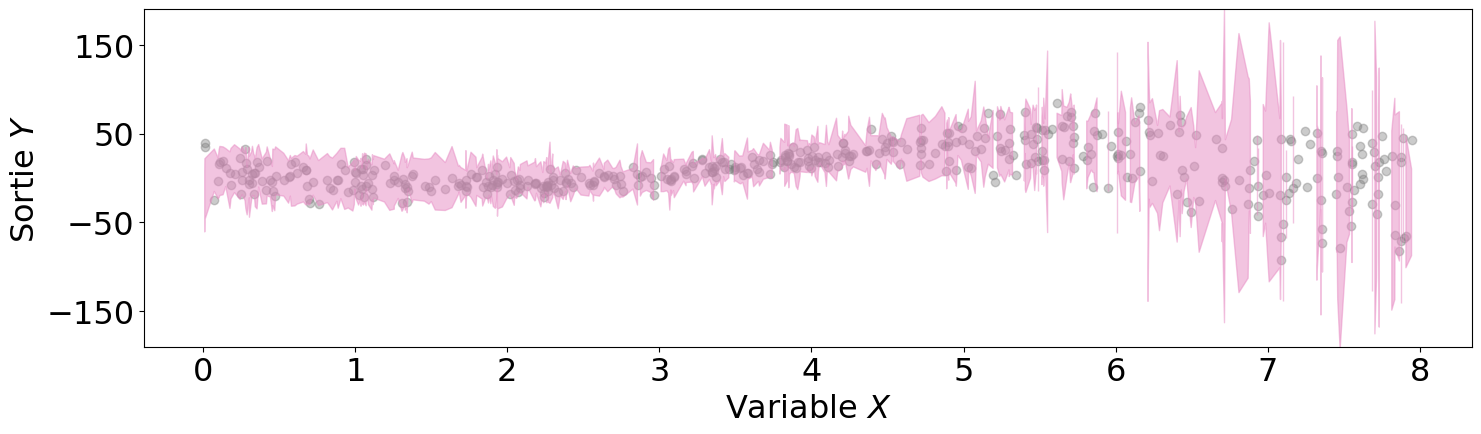

In [130]:
feature = 0
indices = np.argsort(X_test_0[:,feature])
set2_colors = sns.color_palette("Set2")

fig, ax = plt.subplots(figsize=(15,4.5))
fig.subplots_adjust(left=0.09,right=0.975,top=0.95,bottom=0.2,wspace=0.25, hspace=0.25)

ax.scatter(X_test_0[indices,feature], Y_test[indices], alpha=0.4,color = "tab:grey")
ax.fill_between(X_test_0[indices,feature], predictions[indices]
                 -np.array(q_pcp)[indices], predictions[indices]
                 +np.array(q_pcp)[indices], alpha=0.5,color= set2_colors[3])
ax.set_xlabel("Variable $X$", fontsize=23)
ax.set_ylabel("Sortie $Y$",fontsize=23)
ax.tick_params(axis='x', labelsize=23)
ax.tick_params(axis='y', labelsize=23)
ax.set_yticks(np.arange(-150, 151, step=100))
ax.set_ylim(-190,190)
plt.show()


In [132]:
feature = 0

x_grid = np.linspace(0, 8, 2000)
indices = np.argsort(X_test[:,feature])
coverage_scp_1 = []
coverage_cc_1 = []
coverage_rlcp_1 = []
coverage_pcp_1 = []

for x in tqdm(x_grid):
    idx = np.array(abs(x - X_test_0[:,feature])).argsort()[:250]
    coverage_scp_1.append(np.mean(np.array(q_scp)[idx]>=R_test[idx]))
    coverage_cc_1.append(np.mean((Y_test[idx]>=np.array(lbs)[idx])*(Y_test[idx]<=np.array(ubs)[idx])))
    coverage_rlcp_1.append(np.mean(np.array(q_rlcp)[idx]>=R_test[idx]))
    coverage_pcp_1.append(np.mean(np.array(q_pcp)[idx]>=R_test[idx]))


100%|██████████| 2000/2000 [00:00<00:00, 3193.75it/s]


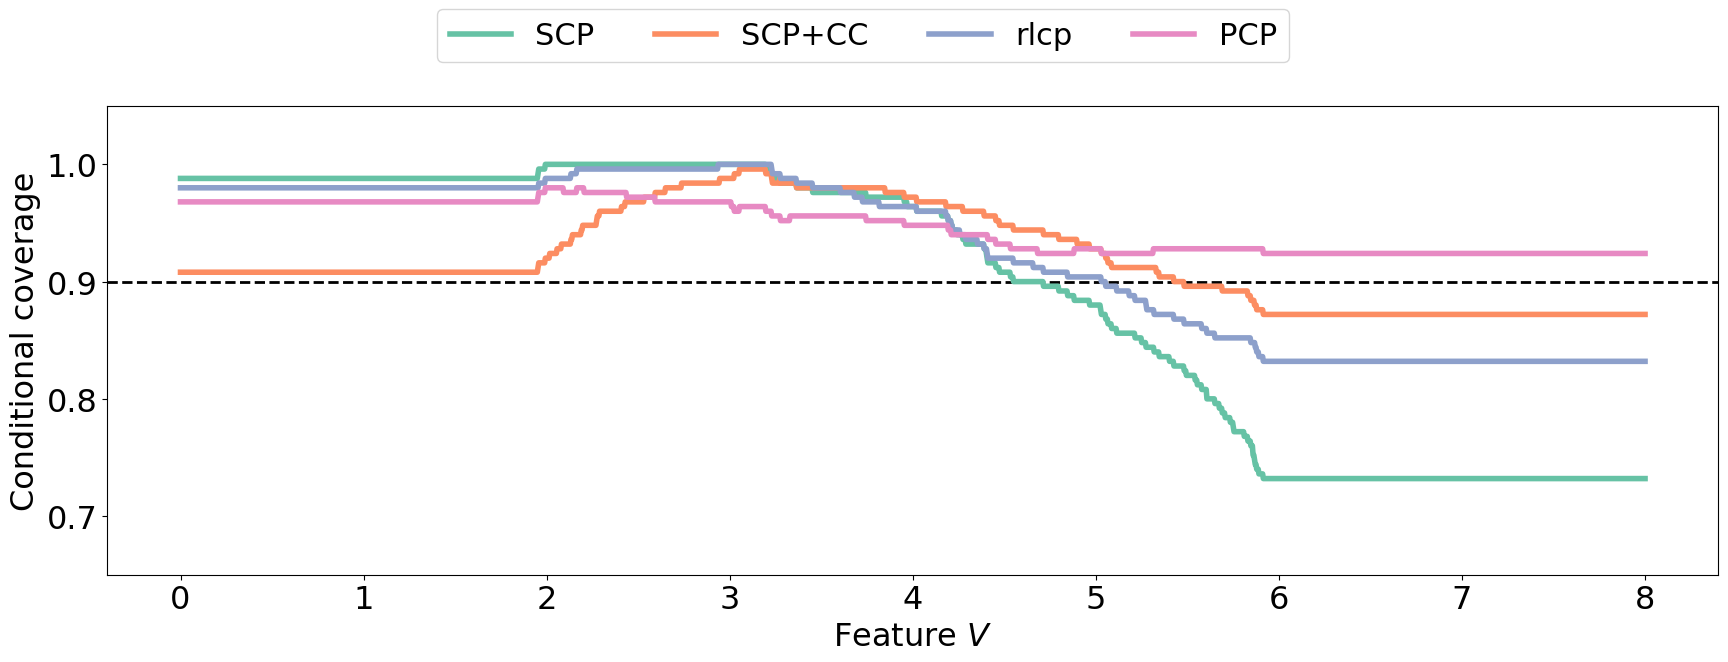

In [133]:
set2_colors = sns.color_palette("Set2")
fig, ax = plt.subplots(figsize=(18,7))
fig.subplots_adjust(left=0.08,right=0.975,top=0.82,bottom=0.15,wspace=0.25, hspace=0.25)
ax.axhline(y=0.9, color='black', linestyle='--', linewidth=2)
h1,=ax.plot(x_grid, np.array(coverage_scp_1), color=set2_colors[0], linewidth=4,label = "SCP")
h2,=ax.plot(x_grid, np.array(coverage_cc_1), color=set2_colors[1], linewidth=4,label = "SCP+CC")
h3,=ax.plot(x_grid, np.array(coverage_rlcp_1), color=set2_colors[2], linewidth=4,label = "rlcp")
h4,=ax.plot(x_grid, np.array(coverage_pcp_1), color=set2_colors[3], linewidth=4,label = "PCP")
fig.legend([h1,h2,h3,h4], ['SCP', 'SCP+CC', 'rlcp', 'PCP'], loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.98), fontsize=22)
ax.tick_params(axis='x', labelsize=23)
ax.tick_params(axis='y', labelsize=23)
ax.set_xlabel("Feature $V$", fontsize=23)
ax.set_ylabel("Conditional coverage", fontsize=23)
ax.set_ylim((0.65,1.05))
ax.set_yticks(np.arange(0.7, 1.01, step=0.1))

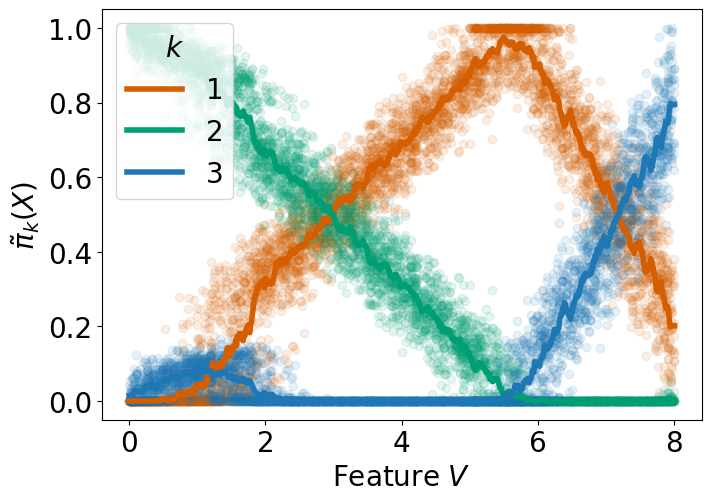

In [ ]:
feature = 0
data_test = X_test_0[:,feature]
x_grid = np.linspace(0, 8,1000)
pi = np.array(pi_list)
N, K = np.shape(pi_list)

my_dict = {}
for k in range(K):
    my_dict[str(k)] = []
    for x in x_grid:
        idx = np.array(abs(x - data_test )**2).argsort()[:50]
        my_dict[str(k)].append(np.mean(pi[idx,k]))

fig, ax = plt.subplots(layout='constrained', figsize=(7,4.9))

ax.scatter(data_test, pi[:,0],color = "#D55E00",alpha=0.1)
ax.scatter(data_test, pi[:,1],color = "#009E73",alpha=0.1)
ax.scatter(data_test, pi[:,2],color = "tab:blue",alpha=0.1)
ax.plot(x_grid, my_dict[str(0)], linewidth=4,color = "#D55E00",label = '$1$')
ax.plot(x_grid, my_dict[str(1)], linewidth=4,color = "#009E73",label = '$2$')
ax.plot(x_grid, my_dict[str(2)], linewidth=4,color = "tab:blue",label = '$3$')
ax.set_ylabel(r'$\tilde{\pi}_k(X)$',fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.set_xlabel("Feature $V$", fontsize=20)
ax.tick_params(axis='y', labelsize=20)
legend = ax.legend(title="$k$",loc='upper left',   fontsize=20)
plt.setp(legend.get_title(), fontsize=20)

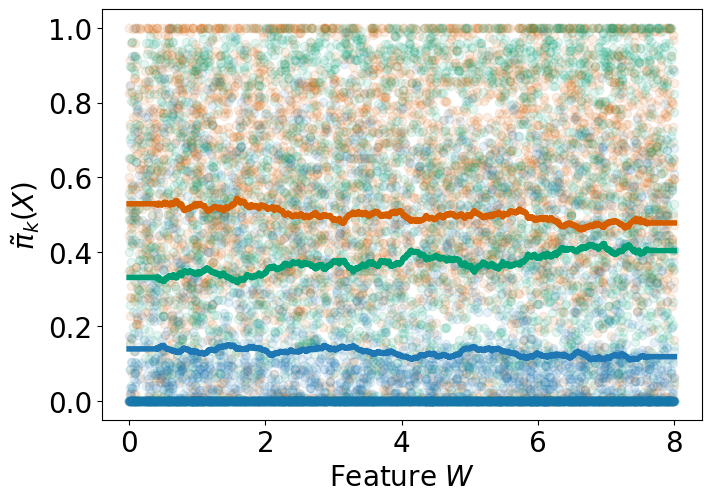

In [ ]:
feature = 1
data_test = X_test_0[:,feature]
x_grid = np.linspace(0, 8,2000)
pi = np.array(pi_list)
N, K = np.shape(pi_list)

my_dict = {}
for k in range(K):
    my_dict[str(k)] = []
    for x in x_grid:
        idx = np.array(abs(x - data_test )**2).argsort()[:500]
        my_dict[str(k)].append(np.mean(pi[idx,k]))

fig, ax = plt.subplots(layout='constrained', figsize=(7,4.9))

ax.scatter(data_test, pi[:,0],color = "#D55E00",alpha=0.1)
ax.scatter(data_test, pi[:,1],color = "#009E73",alpha=0.1)
ax.scatter(data_test, pi[:,2],color = "tab:blue",alpha=0.1)
ax.plot(x_grid, my_dict[str(0)], linewidth=4,color = "#D55E00",label = '$1$')
ax.plot(x_grid, my_dict[str(1)], linewidth=4,color = "#009E73",label = '$2$')
ax.plot(x_grid, my_dict[str(2)], linewidth=4,color = "tab:blue",label = '$3$')
ax.set_ylabel(r'$\tilde{\pi}_k(X)$',fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.set_xlabel("Feature $W$", fontsize=20)
ax.tick_params(axis='y', labelsize=20)